In [1]:
# For display purposes
%matplotlib inline
from IPython.core.display import HTML
table_css = 'table {display: inline-block} '
HTML('<style>{}</style>'.format(table_css))

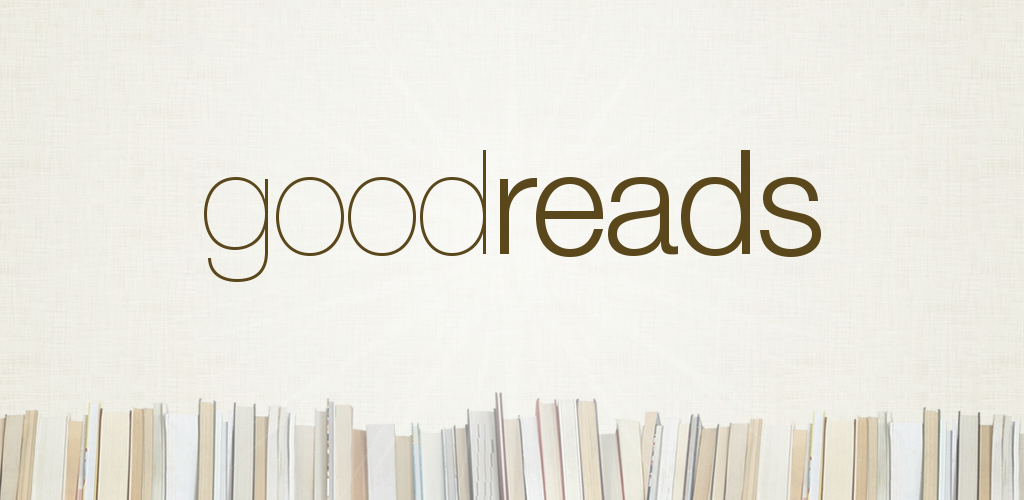

Goodreads stands as a vibrant social media hub designed exclusively for book enthusiasts, offering a dedicated space for the sharing and evaluation of literary works. Within its digital realm, a vast repository of books is meticulously cataloged, featuring essential details such as titles, authors, publishers, as well as insightful quotations and reviews contributed by the platform's active user community.

Delving into the intricacies of this literary landscape, the Goodreads.ipynb notebook embarks on a journey to unravel compelling insights. Through systematic exploration, we discover some interesting results, including how things have changed over time and how various parameters correlate. 

## Project Goal

     In this notebook, our primary goal is to investigate how these parameters are clustered by leveraging the K-Means algorithm and then use this idea to develop a book recommendation system.

# Table of contents
1. [Dataset](#dataset)
2. [Loading the dataset and modules](#loading)
3. [Pre-processing data](#pre-process)
4. [Identifying clusters in the data (K-Means Algorithm)](#K-means)
    1. [Choosing the number of clusters](#choosing-n-clusters)
    2. [Visualizing the clusters](#cluster-visuals)
        1. [Scatter plots](#scatter)
        2. [Heatmaps](#heatmaps)
5. [Book recommendation system](#recommender)

# Dataset

The raw data used here is obtained using a dedicated web scraping tool developed for this project: 
<a href="https://github.com/EmmaKLofthouse/goodreads_scraper">goodreads_scraper</a>. 

This provides the following variables for each book:

| Column             | Description                         |
|  ----------------  |   :-------  |
| title              | The book title                      |
| Number of pages    | Number of pages in the book         |
| Language           | Language of text                    |
| Author             | Author's Name                       |
| Rating Value       | Average rating. From 0 to 5         |
| Rating Count       | Total number of ratings             |
| Review Count       | Total number of written reviews     |
| ISBN               | International Standard Book Number  |                       
| Publication Date   | Date of publication                 |     

This data has been cleaned as shown in the Goodreads.ipynb notebook. 

# Load the dataset and required modules 
<a name="loading"></a>


First, we read in the cleaned csv file containing data on the scraped books and convert it to a pandas dataframe for easy manipulation. 

In [3]:
df = pd.read_csv('goodreads_data_clean.csv')
df = df[df.num_ratings>10] #exclude entries with very few ratings

In [4]:
df.head()

,title,num_pages,lang,author,avg_rating,num_ratings,num_reviews,pub_date_string,pub_date,year,month,day
0,Lottery Master Guide: Turn a Game of Chance In...,192,English,Gail Howard,3.98,46,4,"First published April 1, 1997",1997-04-01,1997,4,1
2,Lottery Winners&apos; Guide: When It Happens T...,128,English,Shayne Jones,2.94,16,1,"First published January 25, 2006",2006-01-25,2006,1,25
3,Solar Lottery,188,English,Philip K. Dick,3.49,4686,349,"First published January 1, 1955",1955-01-01,1955,1,1
4,"The Lucky Lottery (A to Z Mysteries, #12)",86,English,Ron Roy,4.06,3008,105,"First published November 28, 2000",2000-11-28,2000,11,28
5,Combinatorial Lottery Systems (Wheels) with Gu...,304,English,Iliya Bluskov,4.22,23,2,"First published February 1, 2002",2002-02-01,2002,2,1


In [30]:
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d import Axes3D

# models
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

In [5]:
df.columns

Index(['title', 'num_pages', 'lang', 'author', 'avg_rating', 'num_ratings',
       'num_reviews', 'pub_date_string', 'pub_date', 'year', 'month', 'day'],
      dtype='object')

# Pre-processing data <a name='pre-process'></a>

Before we begin, we need to do some additional pre-processing. Firstly, there are some columns in the imported database that are not needed for our current project. For clarity and efficiency we can simply remove them now.

In [6]:
# Drop all the publication date columns except the year
df = df.drop(['pub_date_string', 'pub_date', 'month', 'day'],axis=1)

In addition, there is some categorical data where the variables are nominal (i.e. no inherent order or numerical relationship between categories). For the algorithms to work these columns need to be adapt. Specifically we will use one-hot encoding to convert each category into a binary column, representing the presence or absence of that category.

In [7]:
df_encoded = pd.get_dummies(df, columns=['lang'], prefix='lang')

In [8]:
df_encoded.head()

,title,num_pages,author,avg_rating,num_ratings,num_reviews,year,lang_Afrikaans,lang_Arabic,lang_Basque,...,lang_Romanian,lang_Russian,lang_Sanskrit,lang_Spanish; Castilian,lang_Swedish,lang_Turkish,lang_Urdu,lang_Vietnamese,lang_Welsh,lang_Yiddish
0,Lottery Master Guide: Turn a Game of Chance In...,192,Gail Howard,3.98,46,4,1997,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lottery Winners&apos; Guide: When It Happens T...,128,Shayne Jones,2.94,16,1,2006,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Solar Lottery,188,Philip K. Dick,3.49,4686,349,1955,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Lucky Lottery (A to Z Mysteries, #12)",86,Ron Roy,4.06,3008,105,2000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Combinatorial Lottery Systems (Wheels) with Gu...,304,Iliya Bluskov,4.22,23,2,2002,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It is probably also useful to one-hot encode the author data but due to the high number of values (which would lead to a very high number of new binary columns) and limited computer resources, this is not currently possible in my case. Instead, I decide to drop this parameter from my clustering experiment

In [9]:
n_authors = df['author'].nunique()
print(f"There are {n_authors} different authors in the dataset.")

There are 32228 different authors in the dataset.


# Identifying clusters in the data (K-Means Algorithm) <a name='K-means'></a>

The K-Means algorithm, a powerful unsupervised machine learning technique, serves as a versatile tool for data clustering and pattern recognition. Operating on the principle of partitioning a dataset into distinct groups based on similarity, K-Means endeavors to minimize the intra-cluster variance while maximizing the inter-cluster variance.

For our goodreads dataset, we use the algorithm to categorize books that share similar characteristics into the same cluster, allowing for the exploration of underlying trends and patterns within the literary landscape.
By implementing K-Means on this specific dataset, we aim to uncover inherent structures and relationships among books. 

In [10]:
# Drop the features that won't be used for clustering
X = df_encoded.drop(['author','title'],axis=1)

In [11]:
X.columns

Index(['num_pages', 'avg_rating', 'num_ratings', 'num_reviews', 'year',
       'lang_Afrikaans', 'lang_Arabic', 'lang_Basque', 'lang_Bulgarian',
       'lang_Catalan; Valencian', 'lang_Chinese', 'lang_Croatian',
       'lang_Czech', 'lang_Danish', 'lang_Dutch; Flemish',
       'lang_Eastern Frisian', 'lang_English',
       'lang_English, Middle (1100-1500)', 'lang_English, Old (ca.450-1100)',
       'lang_Esperanto', 'lang_Finnish', 'lang_French',
       'lang_Gaelic; Scottish Gaelic', 'lang_Galician', 'lang_German',
       'lang_Greek, Ancient (to 1453)', 'lang_Greek, Modern (1453-)',
       'lang_Hebrew', 'lang_Hmong', 'lang_Hungarian', 'lang_Indonesian',
       'lang_Iranian (Other)', 'lang_Irish', 'lang_Italian', 'lang_Japanese',
       'lang_Kannada', 'lang_Korean', 'lang_Latin', 'lang_Lithuanian',
       'lang_Malay', 'lang_Multiple languages', 'lang_Navajo; Navaho',
       'lang_Norwegian', 'lang_Norwegian Nynorsk; Nynorsk, Norwegian',
       'lang_Persian', 'lang_Polish', 'lang

In [12]:
print(f"The average rating ranges from {min(df.avg_rating)} to {max(df.avg_rating)}.")
print(f"The number of ratings ranges from {min(df.num_ratings)} to {max(df.num_ratings)}.")  

The average rating ranges from 2.0 to 5.0.
The number of ratings ranges from 11 to 9870705.


The range of values in each of these numeric columns varies significantly. For example, the average rating column has a very small range, from 1 to 5. On the other hand, parameters such as the number of ratings vary by orders of magnitude from 0 to almost 9 million!

Therefore, it is important to scale these features so that specific features are not considered more important that others. Note that we do NOT want to scale the one-hot encoded features! These variables are binary values (0 or 1) and their values do not have a meaningful scale in the same way as numerical features. 

In [13]:
numerical_features = ['num_pages', 'avg_rating', 'num_ratings', 'num_reviews', 'year']
one_hot_encoded_features = [col for col in X.columns if col not in numerical_features]

# Scale only the numerical features
scaler = StandardScaler()
X_scaled_numerical = X[numerical_features].copy()
X_scaled_numerical[numerical_features] = scaler.fit_transform(X[numerical_features])

# Combine the scaled numerical features with the one-hot encoded features
X_scaled = pd.concat([X_scaled_numerical, X[one_hot_encoded_features]], axis=1)

## Choosing the number of clusters <a name="choosing-n-clusters"></a>
To determine how many clusters to use, one common method is the 'Elbow method'. This strategy helps us to determine the optimal number of clusters by analyzing the relationship between the number of clusters (K) and the within-cluster sum of squares (WCSS). 

We run K-Means for different values of K and then plot the resulting WCSS. An "elbow" point, or turn in the profile, is identified at which point adding more clusters provides diminishing returns in reducing WCSS. This number of clusters signifies a balance between capturing meaningful patterns and avoiding excessive granularity, guiding the selection of an appropriate K value for effective clustering.

In [14]:
score = []
testing_range = range(1,15,2)
for cluster in testing_range:
    print(f"Trying {cluster} clusters...")
    kmeans = KMeans(n_clusters = cluster, init="k-means++", random_state=42)
    kmeans.fit(X_scaled[:10000])
    score.append(kmeans.inertia_)

Trying 1 clusters...
Trying 3 clusters...
Trying 5 clusters...
Trying 7 clusters...
Trying 9 clusters...
Trying 11 clusters...
Trying 13 clusters...


Text(0, 0.5, 'WCSS')

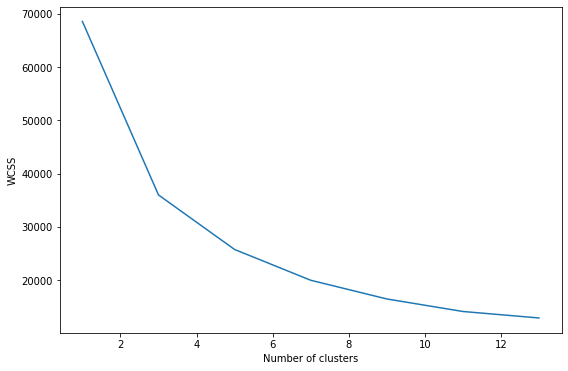

In [15]:
plt.figure(figsize=(9,6))
plt.plot(testing_range, score)
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

The elbow point is not particularly clear in this plot. This is likely due to the data being more heterogenous (as can be seen in plots below) rather than very distinct clusters which tend to show a very clear turn in the profile. However, we can still choose a value and experimentation has shown that the results here do not significantly change with small changes in the chosen number. 

Therefore, in this case **we select N=5 clusters.**

In [16]:
#Rerun code with the selected number of clusters
n_clusters=5

kmeans = KMeans(n_clusters = n_clusters, init="k-means++", random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [17]:
X_scaled['cluster_label'] = kmeans.labels_
X['cluster_label'] = kmeans.labels_

## Visualizing the clusters <a name="cluster-visuals"></a>

### Scatter Plots <a name="scatter"></a>

We can try to visualize what this algorithm has done by plotting the books along various axes and colouring them by their assigned cluster.

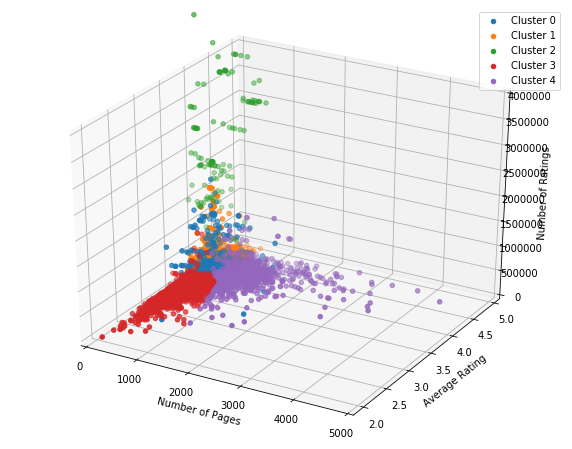

In [18]:
X_subset = X[['num_pages', 'avg_rating', 'num_ratings','cluster_label']]
X_subset = X_subset[:20000]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot points coloured by cluster label
for cluster_label in range(n_clusters):
    cluster_data = X_subset[X_subset['cluster_label'] == cluster_label]
    ax.scatter(cluster_data['num_pages'], cluster_data['avg_rating'], cluster_data['num_ratings'], 
               label=f'Cluster {cluster_label}')

ax.set_xlabel('Number of Pages')
ax.set_ylabel('Average Rating')
ax.set_zlabel('Number of Ratings')
#ax.set_zscale("log")
ax.set_xlim(0,5000)
ax.set_zlim(0,4e6)
plt.legend();

The visualization reveals that books with a substantial number of ratings predominantly fall within Cluster 2 (green). Conversely, books characterized by lower average ratings are predominantly assigned to Cluster 3 (red) and books with a high number of pages are in Cluster 4 (purple).

Below, we plot some of the other parameters in 2D to gain clearer insights into the distinct clusters.

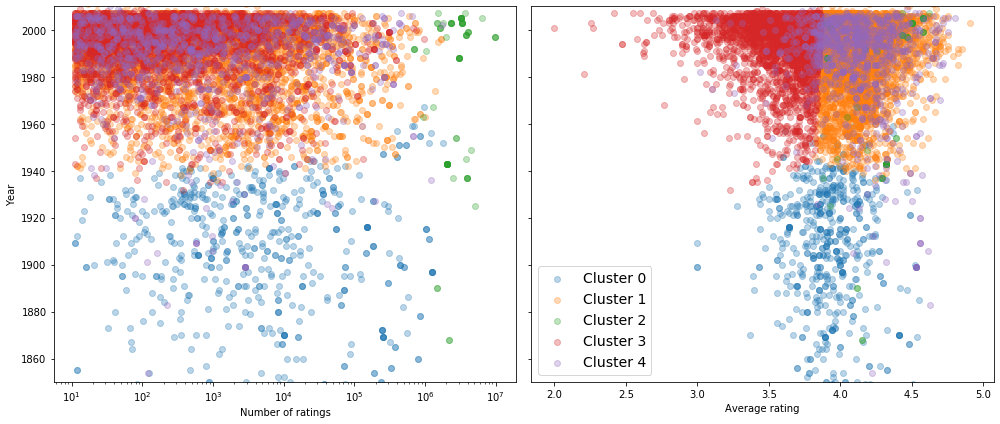

In [19]:
X_subset = X[:10000] #plot a sample of the data for speed and clarity

fig, axes = plt.subplots(1, 2, figsize=(14, 6),sharey=True)
ax1, ax2 = axes[0], axes[1]

for cluster_label in range(n_clusters):
    cluster_data = X_subset[X_subset['cluster_label'] == cluster_label]

    ax1.scatter(cluster_data['num_ratings'], cluster_data['year'], alpha=0.3, label=f'Cluster {cluster_label}')
    ax2.scatter(cluster_data['avg_rating'], cluster_data['year'], alpha=0.3, label=f'Cluster {cluster_label}')

ax1.set_ylim(1850, 2010)
ax1.set_xscale("log")
ax1.set_ylabel("Year")
ax1.set_xlabel("Number of ratings")

ax2.legend(prop={'size': 14})
ax2.set_xlabel("Average rating")

fig.tight_layout()


Here, we observe consistent findings as in the 3D plot: Cluster 3 (red) comprises books with lower ratings, while Cluster 2 (highlighted in green) encompasses those with the highest number of ratings. Additionally, from these plots we discern that Cluster 0 (depicted in blue) encompasses older books published before 1940.

To gain a better and more quantitative view on the properties of each cluster, we can utilize an alternative approach – generating a heatmap of the cluster centroids.

Note: Below I include code to create a pair plot showing the relationships between multiple parameters and the distribution of the different clusters. This cell can take a long time to run hence it is commented out as a default. 

In [20]:

# to_plot = X[['avg_rating','num_ratings','num_pages','cluster_label']] #'num_reviews', 'year'
# to_plot_sample = to_plot.sample(n=2000, random_state=42)

# # Remove outliers
# #sample_exc_label = to_plot_sample.drop('cluster_label', axis=1)
# #to_plot_sample = to_plot_sample.loc[(sample_exc_label < sample_exc_label.quantile(0.995)).all(axis=1)]


# pp = sns.pairplot(to_plot_sample, hue="cluster_label", diag_kind='hist', palette = "Paired", plot_kws={'s': 5},
#                   corner=True) #diag_kws = {'alpha':0.55, 'bins':50}

# pp.axes[0,0].set_xlim((2,5))
# pp.axes[1,0].set_xlim((2,5))
# pp.axes[2,0].set_xlim((2,5))

# #pp.axes[1,0].set_ylim((0,50000))
# pp.axes[1,0].set_yscale("log")
# pp.axes[2,0].set_ylim((0,600))

# pp.axes[1,1].set_xlim((0,20000))
# pp.axes[2,1].set_xlim((0,20000))

# pp.axes[2,2].set_xlim((0,600))


### Heatmap of cluster centroids <a name='heatmaps'></a>
In this visualization, we construct a grid plot where columns correspond to distinct parameters, and rows represent individual clusters. Each cell denotes the mean value of the parameter within the respective cluster. This heatmap provides a comprehensive overview of the characteristic properties and distributions across the multi-dimensional space.

[Text(87.0, 0.5, 'Cluster'), Text(0.5, 50.09375, 'Parameters')]

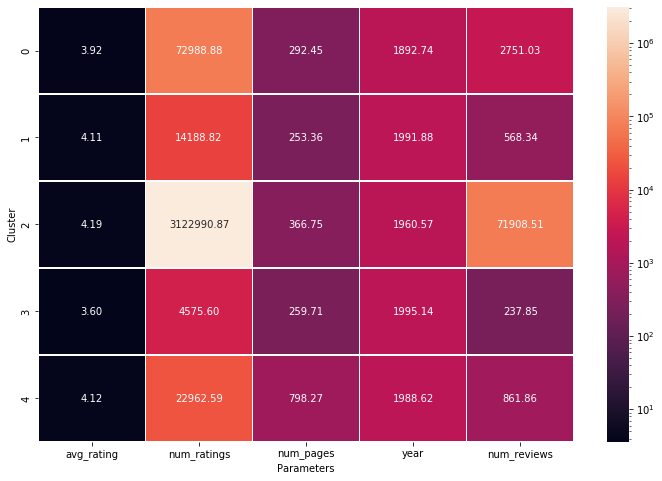

In [21]:
features = ['avg_rating', 'num_ratings', 'num_pages', 'year', 'num_reviews', 'cluster_label']
numeric_features = features[:-1]

# Calculate mean value in each cluster
centroids = X.groupby('cluster_label').mean()

plt.figure(figsize=(12, 8))
ax = sns.heatmap(centroids[numeric_features], annot=True, fmt=".2f", linewidths=.5, norm=LogNorm())
ax.set(xlabel="Parameters", ylabel="Cluster")


This plot is useful, however the interpretation is limited by the different ranges for each parameter. As a result, columns such as average rating and the year, which have a very small dynamical range are all represented by the same colour. 

What we really want to know is not how the cell's value compares to the values of other parameters, but how the cell's value compares the same parameter in other clusters. To achieve this, rather than plotting the mean value of the parameter in that cluster we can plot it's z-score. 



The z-score, also known as standard score or z-value, is a statistical measure that quantifies how many standard deviations a data point is from the mean of a dataset. It's calculated using the formula:

$Z=(X−μ) \over σ$ 

where Z is the z-score, X is the individual data point, μ is the mean of the dataset, σ is the standard deviation of the dataset.

Z-scores help to standardize data and compare individual data points to the overall distribution. A positive z-score indicates that the data point is above the mean, while a negative z-score indicates that it's below the mean. The magnitude of the z-score indicates how far the data point is from the mean in terms of standard deviations.

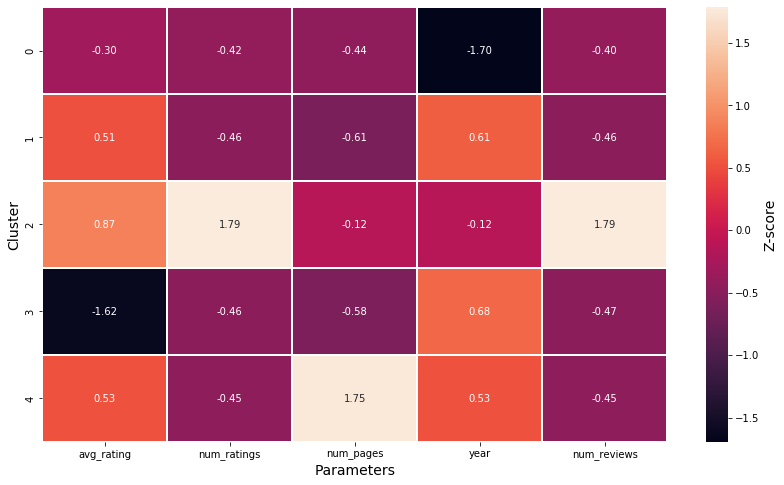

In [22]:
# Calculate Z-scores for each value in the cluster centres
z_scores = (centroids - centroids.mean()) / centroids.std()

# Create a heatmap using Z-scores
plt.figure(figsize=(14, 8))
ax = sns.heatmap(z_scores[numeric_features], annot=True, fmt=".2f", linewidths=.5)

ax.set_xlabel("Parameters", fontsize=14)
ax.set_ylabel("Cluster", fontsize=14)
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Z-score', fontsize=14);

From this heatmap we can now see some of the trends already identified:
- **Cluster 0** contains the books with the oldest publication dates
- **Cluster 1** contains books which have generally good rathings and mostly more recently books. These tend to be books with less extreme values for any of the parameters
- **Cluster 2** contains the books with high numbers of ratings/reviews
- **Cluster 3** contains the books with the lowest average rations
- **Cluster 4** contains the books with the very high page counts

Another key things to know about the clusters is how many members each has. As shown by the value counts below, we see that the bulk of the books are in Clusters 1 and 3 while cluster 2 which contains the most popular books is two orders of magnitude smaller.

In [23]:
X.value_counts('cluster_label')

cluster_label
1    38692
3    28950
4     6931
0     4871
2      301
dtype: int64

# Book recommendation system <a name="recommender"></a>

Now that we've got a better idea of what the data looks like we can move on to the main goal of this project - developing a system to recommend books. 

We want to create a system where we can provide a title (and author) and will in return be provided with a list of the top 5 most similiar books. Before we work on the actual recommender we first need to find a way to identify the book in our database given an input string. To do this we will use CountVectorizer().

CountVectorizer is a feature extraction technique used in natural language processing (NLP) and text mining. It takes of strings and splits it into individual words or terms, then counts the occurrences of each term. These counts are combined into a matrix where each sting is a row and each unique word is a column with the cell values indicating the frequency of each term in each document. We can the compare rows to find ones with are the most similiar.

In [42]:
#Convert every title in the database to a count vector
title_vectorizer = CountVectorizer()
author_vectorizer = CountVectorizer()

title_vectors = title_vectorizer.fit_transform(df["title"])
author_vectors = author_vectorizer.fit_transform(df["author"])

In [41]:
print(f"The title matrix contains...")
print(f"   {title_vectors.shape[0]} rows, one for each book ")
print(f"   {title_vectors.shape[1]} columns, each representing a different potential word in the title.")

The title matrix contains...
   79745 rows, one for each book 
   41585 columns, each representing a different potential word in the title.


In [54]:
def find_closest_title_and_author(input_title, input_author=""):
    input_title_vector = title_vectorizer.transform([input_title])
    input_author_vector = author_vectorizer.transform([input_author])

    # Concatenate title and author vectors
    input_combined_vector = scipy.sparse.hstack([input_title_vector, input_author_vector])

    # Concatenate title and author vectors in the dataframe
    combined_vectors = scipy.sparse.hstack([title_vectors, author_vectors])

    # Compute cosine similarity between the input vector and all combined title and author vectors
    similarities = cosine_similarity(input_combined_vector, combined_vectors)

    # Find the indices of the top 10 most similar titles and authors
    closest_indices = np.argsort(similarities.ravel())[::-1][:10]

    top_titles_authors = [(df.iloc[i]['title'], df.iloc[i]['author']) for i in closest_indices]

    return top_titles_authors


In [93]:
# Example usage
input_title = "Harry Potter" 
input_author = ""
closest_title, closest_author = find_closest_title_and_author(input_title, input_author)[0]

print(f"Closest title to '{input_title}' by '{input_author}': {closest_title} by {closest_author}")

Closest title to 'Harry Potter' by '': Harry Potter Collection (Harry Potter, #1-6) by J.K. Rowling


In [89]:
def select_book(input_title, input_author="", n=5):

    for i in range(n):
        closest_title, closest_author = find_closest_title_and_author(input_title, input_author)[i]

        if input_author == "":
            print(f"Closest title to '{input_title}': {closest_title} by {closest_author}")
        else:
            print(f"Closest title to '{input_title}' by '{input_author}': {closest_title} by {closest_author}")

        while True:
            answer = input("Is this the book you want? (Yes/No): ").strip().lower()

            if answer == "yes":
                return closest_title, closest_author
            elif answer == "no":
                break
            else:
                print("Please answer with 'Yes' or 'No'")

            
    print("Book not found.")
    return None, None


In [91]:
input_title = "Catcher in the rye"
chosen_title, chosen_author = select_book(input_title, input_author)

Closest title to 'Catcher in the rye': The Catcher in the Rye by J.D. Salinger
Is this the book you want? (Yes/No): yes


In [92]:
print(chosen_title, chosen_author)

The Catcher in the Rye J.D. Salinger
